# EDA of testsets, chestXray14

In [72]:
import json
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
from collections import Counter

from sklearn.metrics import accuracy_score
from sklearn.metrics import cohen_kappa_score

### Loading data

In [20]:
# loading the the label sets
chestX_ray14 = pd.read_csv("../../Data/ChestX-ray14/Data_Entry_2017.csv")
bbox_labels_orig = pd.read_csv("../../Data/ChestX-ray14/BBox_List_2017.csv")

gcs16L_orig = pd.read_csv("../Data/gcs-public-data-healthcare-nih-chest-xray-labels/all_findings_expert_labels/test_labels.csv")#, index_col=0)
gcs16L_orig.rename(columns = {'Image ID':'Image Index'}, inplace = True)

gsc4L_val_orig = pd.read_csv("../Data/gcs-public-data-healthcare-nih-chest-xray-labels/four_findings_expert_labels/validation_labels.csv")#, index_col=0)
gcs4L_test_orig = pd.read_csv("../Data/gcs-public-data-healthcare-nih-chest-xray-labels/four_findings_expert_labels/test_labels.csv")#, index_col=0)

# The RSNA files for mapping
RSNA_csv = pd.read_csv('../Data/RSNA/stage_2_train_labels.csv')
mappings_path = '../Data/RSNA/pneumonia-challenge-dataset-mappings_2018.json'
map_file = open(mappings_path)  
mappings = json.load(map_file)  
map_file.close()
mappings_df = pd.DataFrame.from_dict(mappings)

### Loading the dataframes  

In [21]:
# chaning labels to fit like chestX-ray14
bbox_labels_orig["Finding Label"] = bbox_labels_orig["Finding Label"].replace("Infiltrate", "Infiltration")
gcs16L_orig.rename(columns = {'Pleural Thickening':'Pleural_Thickening'}, inplace = True)

In [27]:
# preprocessing the RSNA files
RSNA_csv.rename(columns = {'patientId':'subset_img_id'}, inplace = True)
RSNA_mapping = RSNA_csv.merge(mappings_df, how='inner', on="subset_img_id")
RSNA_mapping = RSNA_mapping.drop_duplicates(subset=['subset_img_id'])
RSNA_mapping.rename(columns = {'img_id':'Image Index'}, inplace = True)
RSNA = RSNA_mapping.merge(chestX_ray14, how='inner', on="Image Index")
RSNA = RSNA[['Image Index', 'Target']]
# RSNA_chest.to_csv("../Data/RSNA/RSNA_preprocessed.csv", index=False)

RSNA["Labels_RSNA"] = RSNA["Target"].replace({0: "No pneumonia", 1: "Pneumonia"})
RSNA = RSNA[["Image Index", "Labels_RSNA"]]

### Raw counts 

In [28]:
print("Total labels from bbox:", len(bbox_labels_orig["Image Index"]))

Total labels from bbox: 984


In [29]:
print("Entire ChestX-ray14:", len(chestX_ray14))
print()
print("Image reviewed intances:")
print("Labelled img from bbox:", len(set(bbox_labels_orig["Image Index"])))
print("Labelled img from gcs, all labels:", len(gcs16L_orig))
print("Labelled img from gcs, four labels val:", len(gsc4L_val_orig))
print("Labelled img from gcs, four labels test:", len(gcs4L_test_orig))
print("Labelled img from RSNA:", len(RSNA))

print()
print("All labels combined:", len(bbox_labels_orig)+len(gcs16L_orig))
print("Four labels combined:", len(gsc4L_val_orig)+len(gcs4L_test_orig))

print()
print("A total of:", len(bbox_labels_orig)+len(gcs16L_orig) + len(gsc4L_val_orig)+len(gcs4L_test_orig), "are annotated by image review")

Entire ChestX-ray14: 112120

Image reviewed intances:
Labelled img from bbox: 880
Labelled img from gcs, all labels: 810
Labelled img from gcs, four labels val: 2414
Labelled img from gcs, four labels test: 1962
Labelled img from RSNA: 26684

All labels combined: 1794
Four labels combined: 4376

A total of: 6170 are annotated by image review


### Labels annotated 

In [32]:
# Checking the labels
ChestX_l = set([i for j in list(chestX_ray14["Finding Labels"]) for i in j.split("|")])
print("labels in ChestX-ray14:", len(ChestX_l))
print(ChestX_l)
print()

bbox_l = set([i for i in list(bbox_labels_orig["Finding Label"])])
print("labels in bbox:", len(bbox_l))
print(bbox_l)
print()

gsc16L_l = set(gcs16L_orig.columns.to_list()[2:])
print("labels in gcs16L_orig:", len(gsc16L_l))
print(gsc16L_l)
print()

gsc4L_l = set(gsc4L_val_orig.columns.to_list()[-5:-1])
print("labels in gsc4L_val_orig:", len(gsc4L_l))
print(gsc4L_l)
print()

RSNA_l = set([i for i in list(RSNA["Labels_RSNA"])])
print("labels in RSNA:", len(RSNA_l))
print(RSNA_l)

labels in ChestX-ray14: 15
{'Consolidation', 'Fibrosis', 'Emphysema', 'Hernia', 'Mass', 'Pneumonia', 'Atelectasis', 'Pneumothorax', 'Infiltration', 'Edema', 'Nodule', 'Pleural_Thickening', 'Cardiomegaly', 'Effusion', 'No Finding'}

labels in bbox: 8
{'Mass', 'Pneumonia', 'Atelectasis', 'Pneumothorax', 'Infiltration', 'Nodule', 'Cardiomegaly', 'Effusion'}

labels in gcs16L_orig: 16
{'Consolidation', 'Fibrosis', 'Emphysema', 'Hernia', 'Abnormal', 'Mass', 'Pneumonia', 'Atelectasis', 'Pneumothorax', 'Infiltration', 'Edema', 'Other', 'Nodule', 'Pleural_Thickening', 'Cardiomegaly', 'Effusion'}

labels in gsc4L_val_orig: 4
{'Airspace opacity', 'Pneumothorax', 'Fracture', 'Nodule or mass'}

labels in RSNA: 2
{'Pneumonia', 'No pneumonia'}


In [33]:
# add Nodule or mass
ChestX_l.add('Nodule or mass')
bbox_l.add('Nodule or mass')
gsc16L_l.add('Nodule or mass')

In [34]:

print("difference between ChestX-ray14 and gsc16L", gsc16L_l-ChestX_l)
print("difference between ChestX-ray14 and gsc16L", ChestX_l-gsc16L_l)

print()
print("difference between bbox_l and gsc16L", gsc16L_l-bbox_l)
print("difference between bbox_l and gsc16L", bbox_l-gsc16L_l)


difference between ChestX-ray14 and gsc16L {'Abnormal', 'Other'}
difference between ChestX-ray14 and gsc16L {'No Finding'}

difference between bbox_l and gsc16L {'Consolidation', 'Fibrosis', 'Emphysema', 'Hernia', 'Abnormal', 'Edema', 'Other', 'Pleural_Thickening'}
difference between bbox_l and gsc16L set()


### Checking if images are reviewed mulitiple time  

In [35]:
print("bbox")
print(len(bbox_labels_orig["Image Index"].to_list()), "images", len(set(bbox_labels_orig["Image Index"].to_list())), "unique images")
print("\ngcs all labels")
print(len(gcs16L_orig["Image Index"].to_list()), "images", len(set(gcs16L_orig["Image Index"].to_list())), "unique images")
print("\ngcs four labels val, test")
print(len(gsc4L_val_orig["Image Index"].to_list()), "images", len(set(gsc4L_val_orig["Image Index"].to_list())), "unique images")
print(len(gcs4L_test_orig["Image Index"].to_list()), "images", len(set(gcs4L_test_orig["Image Index"].to_list())), "unique images")

bbox
984 images 880 unique images

gcs all labels
810 images 810 unique images

gcs four labels val, test
2414 images 2414 unique images
1962 images 1962 unique images


In [36]:
bbox_repeat = list({x for x in bbox_labels_orig["Image Index"].to_list() if bbox_labels_orig["Image Index"].to_list().count(x) > 1})
print(len(bbox_repeat))
print(len(set(bbox_repeat)))


93
93


In [37]:
bbox_labels_orig[bbox_labels_orig["Image Index"] == bbox_repeat[0]]

,Image Index,Finding Label,Bbox [x,y,w,h],Unnamed: 6,Unnamed: 7,Unnamed: 8
308,00008814_010.png,Effusion,195.128889,412.197934,665.600000,105.813333,NaN,NaN,NaN
461,00008814_010.png,Infiltration,205.368889,392.855712,643.982222,86.471111,NaN,NaN,NaN
965,00008814_010.png,Atelectasis,195.527118,407.646823,669.013333,64.853333,NaN,NaN,NaN


In [38]:
img_rev_idx = bbox_labels_orig["Image Index"].to_list() + gcs16L_orig["Image Index"].to_list() + \
    gsc4L_val_orig["Image Index"].to_list() + gcs4L_test_orig["Image Index"].to_list()

print(len(img_rev_idx), "images annotated")
print(len(set(img_rev_idx)), "unique images annotated")
print(len(img_rev_idx) - len(set(img_rev_idx)), "not unique images")

6170 images annotated
5195 unique images annotated
975 not unique images


### Pre-processing the dataframes 

In [39]:
chestXray = chestX_ray14[['Image Index', 'Finding Labels']]
chestXray['Finding Labels'] = chestXray['Finding Labels'].str.replace('|', ', ')

/tmp/ipykernel_4029665/1115665617.py:2: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  chestXray['Finding Labels'] = chestXray['Finding Labels'].str.replace('|', ', ')
/tmp/ipykernel_4029665/1115665617.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  chestXray['Finding Labels'] = chestXray['Finding Labels'].str.replace('|', ', ')


In [40]:
# preprocess bbox df 
bbox_labels = bbox_labels_orig[['Image Index', 'Finding Label']]
bbox_labels = bbox_labels.groupby('Image Index', group_keys=False, sort=False)['Finding Label'].apply(', '.join).reset_index()
bbox_labels.rename(columns={'Finding Label':'Labels_bbox'}, inplace=True)
bbox_labels[bbox_labels["Image Index"] == bbox_repeat[0]]  

,Image Index,Labels_bbox
308,00008814_010.png,"Effusion, Infiltration, Atelectasis"


In [41]:
# Defining the labels 
labels_all = gcs16L_orig.columns[2:]
labels_all_idx = {l:idx for idx,l in enumerate(labels_all)}

labels_four = gsc4L_val_orig.columns[-5:-1]
labels_four_idx = {l:idx for idx,l in enumerate(labels_four)}

# making copies to change values in:
gsc16L = gcs16L_orig.copy()
gsc4L_val_df = gsc4L_val_orig.copy()
gsc4L_test_df = gcs4L_test_orig.copy()

# mapping the "NO" and "YES" to 0 and 1
for i in labels_all:
    gsc16L[i] = gsc16L[i].replace({'NO': 0, 'YES': 1})

for i in labels_four:
    gsc4L_val_df[i] = gsc4L_val_df[i].replace({'NO': 0, 'YES': 1})
    gsc4L_test_df[i] = gsc4L_test_df[i].replace({'NO': 0, 'YES': 1})
    
# making a labels column containint all the labels annotated by image review
gsc16L['Labels_all'] = gsc16L[labels_all].astype('bool').apply(lambda row: ", ".join(labels_all[row]), axis=1)

gsc4L_val_df['Labels_four'] = gsc4L_val_df[labels_four].astype('bool').apply(lambda row: ", ".join(labels_four[row]), axis=1)
gsc4L_test_df['Labels_four'] = gsc4L_test_df[labels_four].astype('bool').apply(lambda row: ", ".join(labels_four[row]), axis=1)

# concatenating val and test and keeping only relevant columns 
gsc4L = pd.concat([gsc4L_val_df, gsc4L_test_df])

# keeping only relevant columns 
gsc16L = gsc16L[['Image Index', 'Labels_all']]
gsc4L = gsc4L[['Image Index', 'Labels_four']]


In [42]:
# Adding the label Nodul or mass 
def add_nodule_or_mass(row, column_name, true):
    if "Nodule" in row[column_name] or "Mass" in row[column_name]:
        return row[column_name] + ", Nodule or mass"
    else:
        return row[column_name]

gsc16L["Labels_all"] = gsc16L.apply(add_nodule_or_mass, args=("Labels_all", True), axis=1)
bbox_labels["Labels_bbox"] = bbox_labels.apply(add_nodule_or_mass, args=("Labels_bbox", True), axis=1)
chestXray["Finding Labels"] = chestXray.apply(add_nodule_or_mass, args=("Finding Labels", False), axis=1)

/tmp/ipykernel_4029665/2506082899.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  chestXray["Finding Labels"] = chestXray.apply(add_nodule_or_mass, args=("Finding Labels", False), axis=1)


In [43]:
# check that is works
gsc16L[gsc16L["Image Index"] == "00012291_008.png"]["Labels_all"].tolist()

['Abnormal, Atelectasis, Nodule, Nodule or mass']

### Checking dublicates again, and agreement between the annotations 

In [45]:
img_rev_idx = bbox_labels["Image Index"].to_list() + gsc16L["Image Index"].to_list() + \
    gsc4L_val_df["Image Index"].to_list() + gsc4L_test_df["Image Index"].to_list()

print(len(img_rev_idx), "images annotated")
print(len(set(img_rev_idx)), "unique images annotated")
print(len(img_rev_idx) - len(set(img_rev_idx)), "not unique images")

6066 images annotated
5195 unique images annotated
871 not unique images


In [46]:
dublicates = [x for x in img_rev_idx if img_rev_idx.count(x) > 1]
print(len(dublicates))
print(len(set(dublicates)))
dublicates = list(set(dublicates))

1716
845


In [47]:
print(len([i for i in bbox_labels["Image Index"] if i in dublicates]), "dublicates in bbox_labes")
print(len([i for i in gsc16L["Image Index"] if i in dublicates]), "dublicates in gsc16L")
print(len([i for i in gsc4L["Image Index"] if i in dublicates]), "dublicates in gsc4L")

61 dublicates in bbox_labes
810 dublicates in gsc16L
845 dublicates in gsc4L


In [48]:
print(len([i for i in list(bbox_labels["Image Index"]) if i in list(gsc16L["Image Index"])]), "images annotated by both bbox_labes and gsc16L")
print(len([i for i in list(bbox_labels["Image Index"]) if i in list(gsc4L["Image Index"])]), "images annotated by both bbox_labes and gsc4L")
print(len([i for i in list(gsc16L["Image Index"]) if i in list(gsc4L["Image Index"])]), "images annotated by both gsc16L and gsc4L")

"""
all images in gsc16L is also annotated in the gsc4L
"""

print()
print(len([i for i in list(bbox_labels["Image Index"]) if i in list(RSNA["Image Index"])]), "images annotated by both bbox_labes and RSNA")
print(len([i for i in list(gsc4L["Image Index"]) if i in list(RSNA["Image Index"])]), "images annotated by both gsc4L and RSNA")
print(len([i for i in list(gsc16L["Image Index"]) if i in list(RSNA["Image Index"])]), "images annotated by both gsc16L and RSNA")


26 images annotated by both bbox_labes and gsc16L
61 images annotated by both bbox_labes and gsc4L
810 images annotated by both gsc16L and gsc4L

346 images annotated by both bbox_labes and RSNA
1143 images annotated by both gsc4L and RSNA
192 images annotated by both gsc16L and RSNA


In [49]:
# Looking at all labels
def label_stats(df, label_list, col1, col2):
    
    image_idx = []
    for idx, row in df.iterrows():

        col1_list = [i.strip(" ") for i in row[col1].split(",")]
        col2_list = [i.strip(" ") for i in row[col2].split(",")]

        for label in label_list:
            if label in col1_list and label in col2_list or label not in col1_list and label not in col2_list:
                continue
            else:
                image_idx.append(row["Image Index"])

    # ensure unique image idx            
    image_idx = set(image_idx)        
    print(len(image_idx), "Images with disagreement on at least one label")
    print(len(df)-len(image_idx), "Images with complete agreement")

    print("Percentages of agreement:", (len(df)-len(image_idx))/len(df)*100)
        
    return image_idx

In [50]:
# looking at 1 label at a time 
def my_func(row, column_name, label):
    labels = [i.strip(" ") for i in row[column_name].split(",")]
    if label in labels:
        return 1
    else:
        return 0

def label_stats_one(df, label, col1, col2):
    
    df[label+"1_bin"] = df.apply(my_func, args=(col1, label), axis=1)
    df[label+"2_bin"] = df.apply(my_func, args=(col2, label), axis=1)
    
#     print(Counter(df[col1+"_bin"]))
#     print(Counter(df[col2+"_bin"]))

    acc = accuracy_score(df[label+"1_bin"], df[label+"2_bin"])
    cohens_kappa = cohen_kappa_score(df[label+"1_bin"], df[label+"2_bin"])
    
    print(label)
    print("Accuracy:", acc)
    print("cohen_kappa_score:", cohens_kappa)
    
    if cohens_kappa <= 0.20:
        print("No agreement")
    if cohens_kappa >= 0.21 and cohens_kappa <= 0.39:
        print("Minimal agreement")
    if cohens_kappa >= 0.40 and cohens_kappa <= 0.59:
        print("Weak agreement")
    if cohens_kappa >= 0.60 and cohens_kappa <= 0.79:
        print("Moderate agreement")
    if cohens_kappa >= 0.80 and cohens_kappa <= 0.90:
        print("Strong agreement")
    if cohens_kappa > 0.90 :
        print("Almost perfect agreement")
    
    print()
        
    return acc, cohens_kappa

# Comparing labels from image review  

In [51]:
# All dfs are have the columns "Image Index", "Labels_*"

def labels_from_image_review(df1, df2, combined_set_name):
    print(combined_set_name)
    
    df1_c = df1.columns.to_list()
    df2_c = df2.columns.to_list()
    
    df1_l = set([i.strip(" ") for j in list(df1[df1_c[1]]) for i in j.split(",")])
    df2_l = set([i.strip(" ") for j in list(df2[df2_c[1]]) for i in j.split(",")])

    shared_labels = df1_l.intersection(df2_l)
    print(shared_labels)
    print(df1_l)
    print(df2_l)
    
    # Looking at all shared labels at the same time
    combined = df1.merge(df2, how='inner', on="Image Index")
    incorrect = label_stats(combined, shared_labels, df1_c[1], df2_c[1])
    print()
    
                
    # looking at shared labels individually
    accuracy = []
    kappa_dict = {"Sets": combined_set_name}
    for l in list(shared_labels):
        acc, coh = label_stats_one(combined, l, df1_c[1], df2_c[1])
        accuracy.append(acc)
        kappa_dict[l] = coh
    
    print("---------------------------------------------")
    print()
        
    return pd.DataFrame(data=kappa_dict, index=[0])

In [52]:
gsc4L.columns.to_list()

['Image Index', 'Labels_four']

In [53]:
kappa_df1 = labels_from_image_review(bbox_labels, gsc4L, "BBox + GCS4L")

kappa_df2 = labels_from_image_review(bbox_labels, gsc16L, "BBox + GCS16L")

kappa_df3 = labels_from_image_review(bbox_labels, RSNA, "BBox + RSNA")

kappa_df4 = labels_from_image_review(gsc4L, gsc16L, "GCS4L + GCS16L")

# have no shared labels 
# kappa_df5 = labels_from_image_review(gsc4L, RSNA, "Four + RSNA")

kappa_df5 = labels_from_image_review(gsc16L, RSNA, "All + RSNA")

kappa_df = pd.concat([kappa_df1, kappa_df2, kappa_df3, kappa_df4, kappa_df5])
kappa_df.set_index('Sets', inplace=True)


BBox + GCS4L
{'Pneumothorax', 'Nodule or mass'}
{'Nodule or mass', 'Mass', 'Pneumonia', 'Atelectasis', 'Pneumothorax', 'Infiltration', 'Nodule', 'Cardiomegaly', 'Effusion'}
{'', 'Airspace opacity', 'Nodule or mass', 'Fracture', 'Pneumothorax'}
10 Images with disagreement on at least one label
51 Images with complete agreement
Percentages of agreement: 83.60655737704919

Pneumothorax
Accuracy: 0.9508196721311475
cohen_kappa_score: 0.7004909983633387
Moderate agreement

Nodule or mass
Accuracy: 0.8852459016393442
cohen_kappa_score: 0.6834692364714603
Moderate agreement

---------------------------------------------

BBox + GCS16L
{'Nodule or mass', 'Mass', 'Pneumonia', 'Atelectasis', 'Pneumothorax', 'Infiltration', 'Nodule', 'Cardiomegaly', 'Effusion'}
{'Nodule or mass', 'Mass', 'Pneumonia', 'Atelectasis', 'Pneumothorax', 'Infiltration', 'Nodule', 'Cardiomegaly', 'Effusion'}
{'', 'Consolidation', 'Fibrosis', 'Nodule', 'Emphysema', 'Nodule or mass', 'Hernia', 'Abnormal', 'Mass', 'Pneumoni

## Exploring the inconsistency between labels from report parsing and image review

In [55]:
# Checking the labels
print("The labels annotated by image review:", len(labels_four))
print(labels_four.to_list())
print()
print("The labels annotated by report parsing:", len(labels_all))
print(labels_all.to_list())
print()
print("The labels they have in common:")
intersect_labels = labels_all.intersection(labels_four)
print(intersect_labels.to_list())

The labels annotated by image review: 4
['Fracture', 'Pneumothorax', 'Airspace opacity', 'Nodule or mass']

The labels annotated by report parsing: 16
['Abnormal', 'Atelectasis', 'Cardiomegaly', 'Effusion', 'Infiltration', 'Mass', 'Nodule', 'Pneumonia', 'Pneumothorax', 'Consolidation', 'Edema', 'Emphysema', 'Fibrosis', 'Pleural_Thickening', 'Hernia', 'Other']

The labels they have in common:
['Pneumothorax']


In [56]:
kappa_df1 = labels_from_image_review(bbox_labels, chestXray, "BBox + CRX14")

kappa_df2 = labels_from_image_review(gsc4L, chestXray, "GCS4L + CRX14")

kappa_df3 = labels_from_image_review(gsc16L, chestXray, "GCS16L + CRX14")

kappa_df4 = labels_from_image_review(RSNA, chestXray, "RSNA + CRX14")

kappa_df_chest = pd.concat([kappa_df1, kappa_df2, kappa_df3, kappa_df4, kappa_df5])
kappa_df_chest.set_index('Sets', inplace=True)


BBox + CRX14
{'Nodule or mass', 'Mass', 'Pneumonia', 'Atelectasis', 'Pneumothorax', 'Infiltration', 'Nodule', 'Cardiomegaly', 'Effusion'}
{'Nodule or mass', 'Mass', 'Pneumonia', 'Atelectasis', 'Pneumothorax', 'Infiltration', 'Nodule', 'Cardiomegaly', 'Effusion'}
{'Consolidation', 'Fibrosis', 'Emphysema', 'Nodule or mass', 'Hernia', 'Mass', 'Pneumonia', 'Atelectasis', 'Pneumothorax', 'Infiltration', 'Edema', 'Nodule', 'Pleural_Thickening', 'Cardiomegaly', 'Effusion', 'No Finding'}
521 Images with disagreement on at least one label
359 Images with complete agreement
Percentages of agreement: 40.79545454545455

Nodule or mass
Accuracy: 0.9034090909090909
cohen_kappa_score: 0.7345333749751568
Moderate agreement

Mass
Accuracy: 0.9397727272727273
cohen_kappa_score: 0.7300613496932515
Moderate agreement

Pneumonia
Accuracy: 0.9875
cohen_kappa_score: 0.948902027027027
Almost perfect agreement

Atelectasis
Accuracy: 0.8613636363636363
cohen_kappa_score: 0.6596500126806999
Moderate agreement

P

### Plot the kappa scores 

/tmp/ipykernel_4029665/3124248368.py:20: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.collections[0].colorbar.set_ticklabels(colorbar_ticks)#, ticks=[0, 0.1, 0.3, 0.5, 0.7, 0.9])


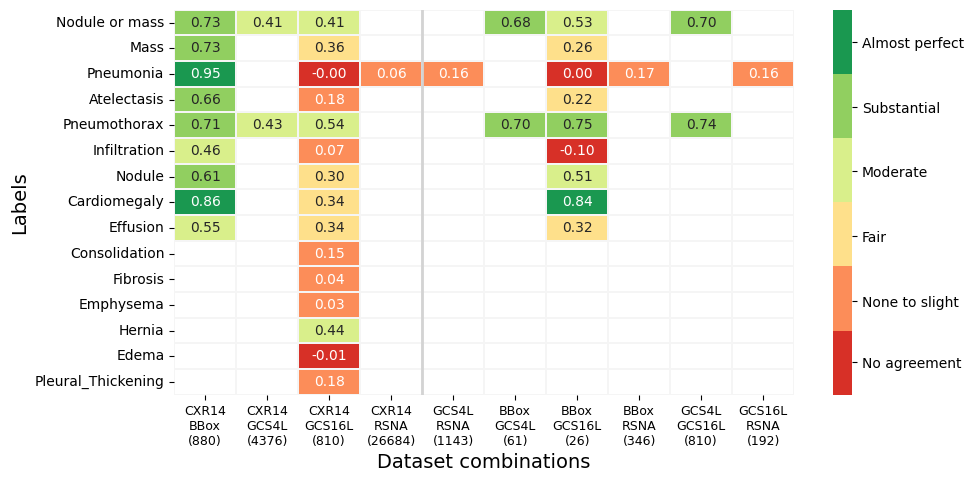

In [69]:
df = pd.concat([kappa_df_chest, kappa_df])
df=df.drop(df.columns[-1], axis=1)
fig, ax = plt.subplots(figsize=(10, 5))

cmap = mpl.colors.ListedColormap(['#d73027', '#fc8d59', '#fee08b', '#d9ef8b', '#91cf60', '#1a9850'])
bounds = [0, 0.2, 0.4, 0.6, 0.8, 1]
norm = mpl.colors.BoundaryNorm(bounds, cmap.N)
colorbar_ticks = ["No agreement", "None to slight", "Fair", "Moderate", "Substantial", "Almost perfect"]

sns.heatmap(df.T, annot=True, cmap=cmap, fmt='.2f', ax=ax, vmin=-0.19, vmax = 1, linewidths= 0.003, linecolor="whitesmoke")
ax.axvline(x=4, linewidth=2, color="lightgrey")
# ax.set_title('Cohens Kappa')
ax.set_ylabel("Labels", fontsize = 14)
ax.set_xlabel("Dataset combinations", fontsize = 14)
labels = ['CXR14\nBBox\n(880)', 'CXR14\nGCS4L\n(4376)', 'CXR14\nGCS16L\n(810)', 'CXR14\nRSNA\n(26684)',
       'GCS4L\nRSNA\n(1143)', 'BBox\nGCS4L\n(61)', 'BBox\nGCS16L\n(26)', 'BBox\nRSNA\n(346)',
       'GCS4L\nGCS16L\n(810)', 'GCS16L\nRSNA\n(192)']
ax.set_xticklabels(labels, rotation=0, fontsize = 9)#, ha='right', rotation_mode="anchor")

ax.collections[0].colorbar.set_ticklabels(colorbar_ticks)#, ticks=[0, 0.1, 0.3, 0.5, 0.7, 0.9])
ax.collections[0].colorbar.set_ticks([-0.09, 0.1, 0.3, 0.5, 0.7, 0.9])

plt.savefig("Cohenskappa_testsets", bbox_inches="tight")
plt.show()

In [70]:
# print dataset sizes again
print("Labels from report parsing")
print(len(bbox_labels.merge(chestXray, how='inner', on="Image Index")),"Bbox") 
print(len(gsc4L.merge(chestXray, how='inner', on="Image Index")),"Four") 
print(len(gsc16L.merge(chestXray, how='inner', on="Image Index")),"All") 
print(len(RSNA.merge(chestXray, how='inner', on="Image Index")),"RSNA") 

print()
print("Label from Images reviews")
print(len(bbox_labels.merge(gsc4L, how='inner', on="Image Index")),"Bbox + four") 
print(len(bbox_labels.merge(gsc16L, how='inner', on="Image Index")),"Bbox + all") 
print(len(bbox_labels.merge(RSNA, how='inner', on="Image Index")),"Bbox + RSNA") 
print(len(gsc16L.merge(gsc4L, how='inner', on="Image Index")),"All + Four")
print(len(gsc16L.merge(RSNA, how='inner', on="Image Index")),"All + RSNA")
print(len(RSNA.merge(gsc4L, how='inner', on="Image Index")),"RSNA + Four")

Labels from report parsing
880 Bbox
4376 Four
810 All
26684 RSNA

Label from Images reviews
61 Bbox + four
26 Bbox + all
346 Bbox + RSNA
810 All + Four
192 All + RSNA
1143 RSNA + Four


## Save the preprocessed dfs 

In [71]:
# only save df with these labels 
labels = {'Effusion', 'Pneumothorax', 'Atelectasis', 'Cardiomegaly', 'Pneumonia'}

In [ ]:
# get the image paths
image_folder_location = {}
for root_dir, dirs, files in os.walk(r"../../../purrlab_students/ChestX-ray14/"):
    for d in dirs:
        for _, _, imgs in os.walk(r'../../../purrlab_students/ChestX-ray14/' + d + '/' + 'images'):
            for img in imgs:
                image_folder_location[img] = d

In [ ]:
# Make binary columns for each label 
def preprocess_df(df):    
    df_c = df.columns.to_list()
    
    df_l = set([i.strip(" ") for j in list(df[df_c[1]]) for i in j.split(",")])
    
    for label in df_l:
        if label != "":
            df[label] = df.apply(my_func, args=(df_c[1], label), axis=1)
            
    df["ImagePath"] = ['../../../purrlab_students/ChestX-ray14/' + image_folder_location[img] + '/images/' + img for img in list(df["Image Index"])]
        
    return df

In [ ]:
gsc16L_pre = preprocess_df(gsc16L.copy())
# gsc16L_pre.to_csv("../Data/Data_splits/GCS16l.csv")
# test = pd.read_csv("../Data/Data_splits/GCS16l.csv", index_col=0)
gsc16L_pre

In [ ]:
bbox_labels
bbox_labels_pre = preprocess_df(bbox_labels.copy())
bbox_labels_pre
# bbox_labels_pre.to_csv("../Data/Data_splits/Bbox.csv")
# test = pd.read_csv("../Data/Data_splits/Bbox.csv", index_col=0)
# test

In [ ]:
gsc4L
gsc4L_pre = preprocess_df(gsc4L.copy())
gsc4L_pre
# gsc4L_pre.to_csv("../Data/Data_splits/GCS4l.csv")
# test = pd.read_csv("../Data/Data_splits/GCS4l.csv", index_col=0)
# test

In [ ]:
RSNA
RSNA_pre = preprocess_df(RSNA.copy())
RSNA_pre
# RSNA_pre = RSNA_pre[["Image Index", "Labels_RSNA", "Pneumonia"]]
# RSNA_pre.to_csv("../Data/Data_splits/RSNA.csv")
# test = pd.read_csv("../Data/Data_splits/RSNA.csv", index_col=0)
# test

## Check overlap with ChestX-ray14 Ann testset

In [73]:
chestX_ray14 = pd.read_csv("../../Data/ChestX-ray14/Data_Entry_2017.csv")

GCS16l = pd.read_csv("../Data/Data_splits/GCS16l.csv", index_col=0)
Bbox = pd.read_csv("../Data/Data_splits/Bbox.csv", index_col=0)
GCS4l = pd.read_csv("../Data/Data_splits/GCS4l.csv", index_col=0)
RSNA = pd.read_csv("../Data/Data_splits/RSNA.csv", index_col=0)

RP_train = pd.read_csv("../Data/Data_splits/tube_detection-RP_train.csv", index_col=0)

In [74]:
RP_train = RP_train.merge(chestX_ray14, how='inner', on="Image Index")
GCS16l = GCS16l.merge(chestX_ray14, how='inner', on="Image Index")
GCS4l = GCS4l.merge(chestX_ray14, how='inner', on="Image Index")
Bbox = Bbox.merge(chestX_ray14, how='inner', on="Image Index")
RSNA = RSNA.merge(chestX_ray14, how='inner', on="Image Index")

In [75]:
print("Original size of GCS16l:", len(GCS16l), "New size:", len(GCS16l[~GCS16l["Patient ID"].isin(RP_train["Patient ID"])]), "Removed:", len(GCS16l) - len(GCS16l[~GCS16l["Patient ID"].isin(RP_train["Patient ID"])]))
print("Original size of GCS4l:", len(GCS4l), "New size:", len(GCS4l[~GCS4l["Patient ID"].isin(RP_train["Patient ID"])]), "Removed:", len(GCS4l) - len(GCS4l[~GCS4l["Patient ID"].isin(RP_train["Patient ID"])]))
print("Original size of Bbox:", len(Bbox), "New size:", len(Bbox[~Bbox["Patient ID"].isin(RP_train["Patient ID"])]), "Removed:", len(Bbox) - len(Bbox[~Bbox["Patient ID"].isin(RP_train["Patient ID"])]))
print("Original size of RSNA:", len(RSNA), "New size:", len(RSNA[~RSNA["Patient ID"].isin(RP_train["Patient ID"])]), "Removed:", len(RSNA) - len(RSNA[~RSNA["Patient ID"].isin(RP_train["Patient ID"])]))


Original size of GCS16l: 810 New size: 602 Removed: 208
Original size of GCS4l: 4376 New size: 3609 Removed: 767
Original size of Bbox: 880 New size: 694 Removed: 186
Original size of RSNA: 26684 New size: 22588 Removed: 4096


In [76]:
# Check with patient ID

In [77]:
# dataset sizes
print("Labels from report parsing")
print(len(RP_train.merge(chestXray, how='inner', on="Image Index")),"RP_train") 

print()
print("Label from Images reviews")
print(len(RP_train.merge(gsc4L, how='inner', on="Image Index")),"RP_train + four") 
print(len(RP_train.merge(gsc16L, how='inner', on="Image Index")),"RP_train+ all") 
print(len(RP_train.merge(RSNA, how='inner', on="Image Index")),"RP_train + RSNA") 
print(len(RP_train.merge(bbox_labels, how='inner', on="Image Index")),"RP_train + bbox_labels")


Labels from report parsing
2835 RP_train

Label from Images reviews
111 RP_train + four
51 RP_train+ all
885 RP_train + RSNA
77 RP_train + bbox_labels
